## Packages

In [24]:
# Cleaning
import pandas as pd, numpy as np, seaborn as sns
import glob
import datetime
import matplotlib.pyplot as plt
import math
from scipy import stats

#Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif

#Models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix


## Input all files

In [226]:
path = r'./player_stats_table' # use your path
files_path = glob.glob(path + "/*.csv")

mutiple_files = [pd.read_csv(file, index_col = None) for file in files_path]
df = pd.concat(mutiple_files, axis  = 0, ignore_index=True)
df.drop(df.columns[0], axis = 1, inplace = True)
print(df.shape)
df.head(5)

(323024, 39)


Date  Game_Index Home_Away Team         Players     MP   FG   FGA  \
0  2018-10-16           1      Home  BOS      Al Horford  29:57  4.0   7.0   
1  2018-10-16           1      Home  BOS    Kyrie Irving  29:00  2.0  14.0   
2  2018-10-16           1      Home  BOS    Jayson Tatum  28:56  9.0  17.0   
3  2018-10-16           1      Home  BOS    Jaylen Brown  28:23  5.0  13.0   
4  2018-10-16           1      Home  BOS  Gordon Hayward  24:37  4.0  12.0   

     FG%   3P  ...  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%   ORtg  \
0  0.571  0.0  ...   0.0  13.1   6.3   9.0   0.0  10.5  28.7  14.3   90.0   
1  0.143  1.0  ...   0.0  13.5   6.5  29.9   0.0   0.0  16.8  25.3   63.0   
2  0.529  1.0  ...   6.3  23.7  14.6  18.4   1.6   0.0   5.0  28.6  125.0   
3  0.385  1.0  ...   9.6   6.9   8.3  10.1   0.0   0.0  12.6  22.9   91.0   
4  0.333  1.0  ...   7.4  11.9   9.6   0.0   7.5   0.0   0.0  21.4   90.0   

   DRtg  
0  80.0  
1  89.0  
2  83.0  
3  89.0  
4  74.0  

[5 rows x 39 columns]

### Delete Playoff Game

In [227]:
# Regular Season or not
def getRegularSeason(table, date_col):
    regularseason = []
    for gameday in table[date_col]:
        d = datetime.date(int(gameday.split("-")[0]),
                          int(gameday.split("-")[1]),
                          int(gameday.split("-")[2]))
        if datetime.date(2006,10,31) <= d <= datetime.date(2007,4,18):
            regularseason.append(1)
        elif datetime.date(2007,10,30) <= d <= datetime.date(2008,4,16):
            regularseason.append(1)
        elif datetime.date(2008,10,28) <= d <= datetime.date(2009,4,16):
            regularseason.append(1)
        elif datetime.date(2009,10,27) <= d <= datetime.date(2010,4,14):
            regularseason.append(1)
        elif datetime.date(2010,10,26) <= d <= datetime.date(2011,4,13):
            regularseason.append(1)
        elif datetime.date(2011,12,25) <= d <= datetime.date(2012,4,26):
            regularseason.append(1)        
        elif datetime.date(2012,10,30) <= d <= datetime.date(2013,4,17):
            regularseason.append(1)    
        elif datetime.date(2013,10,29) <= d <= datetime.date(2014,4,16):
            regularseason.append(1)  
        elif datetime.date(2014,10,28) <= d <= datetime.date(2015,4,15):
            regularseason.append(1)
        elif datetime.date(2015,10,27) <= d <= datetime.date(2016,4,13):
            regularseason.append(1)   
        elif datetime.date(2016,10,25) <= d <= datetime.date(2017,4,12):
            regularseason.append(1)
        elif datetime.date(2017,10,17) <= d <= datetime.date(2018,4,11):
            regularseason.append(1)
        elif datetime.date(2018,10,16) <= d <= datetime.date(2019,4,10):
            regularseason.append(1)
        else:
            regularseason.append(0)
            
    return regularseason


In [228]:
df = df[np.array(getRegularSeason(df, "Date")) == 1]

In [229]:
df.shape

(302018, 39)

### Teams Played by Date

> The following information is used to scrape line-up data.

In [26]:
team_played_date = df.loc[:, ["Date", "Game_Index", "Team"]].drop_duplicates()
team_played_date.reset_index(drop = True, inplace = True)
date_str = team_played_date["Date"].map(str)

def getGameYear(date_col):
    gameYear = []
    for day in date_str:
        if int(day.split("-")[1]) >= 9:
            gameYear.append(day.split("-")[0][-2:])
        else:
            gameYear.append(str(int(day.split("-")[0][-2:]) - 1))
    return gameYear

team_played_date["GameYear"] = getGameYear(date_str)

In [27]:
#team_played_date.to_csv("Team_Played_Date.csv", index = False)

## Cleaning

### Descriptive Statistics: Player Level

In [221]:
df.describe()

Game_Index             FG            FGA            FG%  \
count  302018.000000  302018.000000  302018.000000  287528.000000   
mean        4.942239       3.657140       8.020188       0.440953   
std         3.036210       3.015706       5.605381       0.235302   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       1.000000       4.000000       0.313000   
50%         4.000000       3.000000       7.000000       0.444000   
75%         7.000000       5.000000      11.000000       0.571000   
max        15.000000      24.000000      50.000000       1.000000   

                  3P            3PA            3P%             FT  \
count  302018.000000  302018.000000  187767.000000  302018.000000   
mean        0.765838       2.143515       0.325056       1.712332   
std         1.201762       2.491394       0.309696       2.321787   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.333000       1.000000   
75%         1.000000       4.000000       0.500000       3.000000   
max        14.000000      24.000000       1.000000      25.000000   

                 FTA            FT%  ...           ORB%           DRB%  \
count  302018.000000  175783.000000  ...  301968.000000  301968.000000   
mean        2.252101       0.747852  ...       5.152501      14.729911   
std         2.841572       0.286961  ...       7.793889      12.133294   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.500000  ...       0.000000       6.300000   
50%         2.000000       0.818000  ...       2.800000      12.900000   
75%         4.000000       1.000000  ...       7.800000      21.000000   
max        39.000000       1.000000  ...     100.000000     100.000000   

                TRB%           AST%           STL%           BLK%  \
count  301968.000000  301964.000000  301968.000000  301968.000000   
mean        9.972409      13.244961       1.547255       1.617464   
std         7.996619      15.421724       2.523073       3.441084   
min         0.000000   -1000.000000       0.000000       0.000000   
25%         4.500000       0.000000       0.000000       0.000000   
50%         8.600000       9.800000       0.000000       0.000000   
75%        14.000000      20.100000       2.500000       2.400000   
max       100.000000     100.000000     100.000000     100.000000   

                TOV%           USG%           ORtg           DRtg  
count  292134.000000  301968.000000  301968.000000  301971.000000  
mean       13.454026      19.106303     101.485515     108.277288  
std        15.385453       8.906044      45.970141      14.349637  
min         0.000000       0.000000       0.000000   -1000.000000  
25%         0.000000      13.500000      78.000000     100.000000  
50%        10.700000      18.800000     104.000000     109.000000  
75%        20.000000      24.300000     127.000000     117.000000  
max       100.000000     100.000000     300.000000     162.000000  

[8 rows x 34 columns]

### Abnormal Record

> The minimal number of "AST%" and "DRtg" should not be -1000. That does not make sense at all!!!! <br><br>However, there are only 10 player having this situation during 2007 and 2018, and most importantly, they played very few minutes. That means they barely have any infuence to the team at all. I decided to take the value as NA. In the further step, they will be considered 0 when transforming the table to the team-based level.<br><br> Let's take a look at the meaning of "DRtg": Defensive Rating estimates how many points the player allowed per 100 possessions he individually faced while on the court. It seems unreasonable if the value is negative. Similarly, those who have negative value on "DRtg" barely played on the court. I will also change the negative number to NA.

In [193]:
df.loc[(df["AST%"] == -1000) | (df["DRtg"] == -1000), ["AST", "AST%", "DRtg"]]

Empty DataFrame
Columns: [AST, AST%, DRtg]
Index: []

In [184]:
#df[(df["Date"] == "2019-02-08") & (df["Team"] == "MIL")].loc[:, ['Players', 'MP', 'FG', 'AST', 'AST%']]

In [196]:
df[df["DRtg"] < 0]

Date  Game_Index Home_Away Team                Players  \
2860    2018-11-03           8      Home  SAS       Quincy Pondexter   
21977   2019-03-19           3      Home  LAC    Sindarius Thornwell   
24662   2019-04-05           9      Home  OKC          Deonte Burton   
30035   2009-11-10           4      Home  MEM          Steven Hunter   
33192   2009-12-02           3      Home  CLE        Darnell Jackson   
36079   2009-12-22           2      Home  CHA               Acie Law   
40955   2010-01-24           3      Away  LAC         DeAndre Jordan   
45614   2010-02-28           4      Away  WAS            Mike Harris   
45789   2010-03-01           5      Home  LAC          Brian Skinner   
48405   2010-03-19           2      Home  CHI          Joe Alexander   
50518   2010-04-03           5      Home  MIL             Royal Ivey   
50751   2010-04-04           7      Away  GSW          Devean George   
51698   2010-04-10           8      Away  ATL             Mario West   
56511   2008-11-12           1      Away  ATL             Mario West   
59396   2008-11-30           1      Home  DEN        Renaldo Balkman   
62930   2008-12-25           2      Away  BOS       Brian Scalabrine   
63199   2008-12-27           1      Home  ATL          Solomon Jones   
63976   2009-01-02           3      Home  DAL           Gerald Green   
64107   2009-01-02           9      Away  ATL             Mario West   
64632   2009-01-06           3      Home  DAL          Devean George   
65109   2009-01-09           5      Away  NJN  Chris Douglas-Roberts   
72754   2009-03-06           1      Home  BOS           J.R. Giddens   
72938   2009-03-06          10      Home  UTA           Ronnie Price   
72957   2009-03-07           1      Home  ATL             Mario West   
75026   2009-03-20          10      Home  SAS          Jacque Vaughn   
80206   2009-05-11           1      Home  ATL             Mario West   
80495   2009-05-24           1      Away  CLE         Tarence Kinsey   
84857   2012-11-25           5      Home  PHI         Damien Wilkins   
85563   2012-11-30           6      Away  MIL         Joel Przybilla   
89272   2012-12-25           1      Away  BOS         Jarvis Varnado   
...            ...         ...       ...  ...                    ...   
196500  2011-01-14           8      Home  PHO         Zabian Dowdell   
204610  2011-03-12           8      Away  SAC           Donté Greene   
205646  2011-03-19           4      Home  NOH             Aaron Gray   
213844  2014-11-10           4      Home  LAC       Jared Cunningham   
214282  2014-11-13           4      Away  CHI          E'Twaun Moore   
214416  2014-11-14           7      Home  NYK          Iman Shumpert   
215622  2014-11-21          12      Away  CLE           Lou Amundson   
218724  2014-12-12           3      Home  BRK          Darius Morris   
222125  2015-01-02           8      Home  OKC          Grant Jerrett   
224445  2015-01-17           1      Away  WAS         Garrett Temple   
237790  2015-04-19           2      Home  CLE           Shawn Marion   
237981  2015-04-22           2      Home  LAC          Dahntay Jones   
238685  2015-05-06           2      Away  LAC              Ekpe Udoh   
246360  2015-12-09           8      Away  SAS            Matt Bonner   
246983  2015-12-13           4      Home  TOR        Anthony Bennett   
250615  2016-01-06           2      Away  TOR          Bruno Caboclo   
254115  2016-01-28           1      Home  IND           Solomon Hill   
255196  2016-02-03           9      Home  SAS       Jonathon Simmons   
263347  2016-04-01           3      Away  DAL          Dwight Powell   
266132  2016-04-25           3      Home  POR           Luis Montero   
266447  2016-05-02           1      Home  CLE          Dahntay Jones   
281305  2018-01-17           5      Home  LAC    Sindarius Thornwell   
282895  2018-01-28           2      Home  CLE             Cedi Osman   
285327  2018-02-13           1      Home  DAL         

#### AST%: -1000 to NA

In [230]:
df["AST%"] = [None if i == -1000 else i for i in df["AST"]]

#### DRtg: negative value to NA

In [231]:
df["DRtg"] = [None if i < 0 else i for i in df["DRtg"]]

### Is there NA value in the raw dataset?

In [205]:
# Missing Value
col_has_missing = df.isnull().apply(sum, axis = 0) > 0
missing_value = pd.DataFrame(df.isnull().apply(sum, axis = 0)[col_has_missing]).transpose()
missing_value

FG%     3P%     FT%  +/-    TS%   eFG%   3PAr    FTr  ORB%  DRB%  TRB%  \
0  16229  122491  135441   36  14103  16229  16229  16229    59    59    59   

   STL%  BLK%   TOV%  USG%  ORtg  DRtg  
0    59    59  11211    59    59   154

### Why is there a missing data?

> By checking out the number of missing data in each column, it seems there are some patterns among several columns. I guess the data is missing by certain reasons. So, let's get a closer look.


> **Conclusion 1:** <br> 1. Players who did not play the game would not have a record. <br><br> 2. Taking TOV% as an example, the reason why TOV% is missing is resulted by the zero number of TOV. <br><br> 3. Plus-Minus a.k.a. +/-, simply keeps track of the net changes in score when a given player is either on or off the court. It looks like when a player only plays less than one minute, it would be NA. However, since the player did not have much contribution, I will just take it as a zero. <br><br> **Conclusion 2:** <br> When counting the weighted average, I will ignore the NA value.

#### All Missing Features?

In [29]:
#sum(df.isnull().apply(sum, axis = 1) == len(missing_value.columns)) #19
df[df.isnull().apply(sum, axis = 1) == len(missing_value.columns)].head(5)

Date  Game_Index Home_Away Team          Players    MP   FG  \
5789    2018-11-23           5      Home  DET    José Calderón  0:00  0.0   
80234   2009-05-11           2      Away  DEN  Renaldo Balkman  0:00  0.0   
85899   2012-12-02           1      Away  ORL     Gustavo Ayón  0:00  0.0   
115996  2007-12-20           2      Home  DEN      Bobby Jones  0:00  0.0   
140366  2013-12-02           3      Away  ATL       Pero Antić  0:00  0.0   

        FGA  FG%   3P  ...  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
5789    0.0  NaN  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
80234   0.0  NaN  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
85899   0.0  NaN  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
115996  0.0  NaN  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
140366  0.0  NaN  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

        ORtg  DRtg  
5789     NaN   NaN  
80234    NaN   NaN  
85899    NaN   NaN  
115996   NaN   NaN  
140366   NaN   NaN  

[5 rows x 39 columns]

#### "MP" more than 0:00

In [237]:
# MP: from string to int
df["MP"] = df["MP"].map(lambda x: (int(x.split(":")[0]) * 60 + int(x.split(":")[1])) / 60)

df_played = df[df["MP"] > 0]
col_played_missing = df_played.isnull().apply(sum, axis = 0) > 0
played_missing_value = pd.DataFrame(df_played.isnull().apply(sum, axis = 0)[col_played_missing]).transpose()
played_missing_value

FG%     3P%     FT%  +/-    TS%   eFG%   3PAr    FTr  TOV%  DRtg
0  14440  114201  126188   11  12511  14440  14440  14440  9837    85

#### Percentage %

Including FG%, 3P%, FT%, TS%, eFG%, AST%, TOV%

In [8]:
percentage_missing = played_missing_value.drop(["+/-"], axis = 1).columns
df_played[df_played.loc[:, list(percentage_missing)].isnull().apply(sum, axis = 1) > 0].head(5)

Date  Game_Index Home_Away Team        Players         MP   FG  \
5   2018-10-16           1      Home  BOS   Terry Rozier  26.516667  5.0   
7   2018-10-16           1      Home  BOS  Marcus Morris  20.500000  7.0   
8   2018-10-16           1      Home  BOS    Aron Baynes  19.233333  3.0   
9   2018-10-16           1      Home  BOS   Daniel Theis   4.133333  0.0   
10  2018-10-16           1      Home  BOS   Semi Ojeleye   1.450000  0.0   

     FGA    FG%   3P  ...  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
5   10.0  0.500  1.0  ...   0.0  29.6  14.2   5.5   0.0   3.0   9.1  17.0   
7   12.0  0.583  2.0  ...   8.8  38.2  23.0   0.0   4.5   0.0   7.7  26.0   
8    7.0  0.429  2.0  ...  14.1   5.1   9.8  21.7   0.0   0.0  12.5  17.0   
9    0.0    NaN  0.0  ...   0.0  23.7  11.4   0.0   0.0   0.0   NaN   0.0   
10   0.0    NaN  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   NaN   0.0   

     ORtg  DRtg  
5   102.0  84.0  
7   122.0  74.0  
8   124.0  89.0  
9     0.0  86.0  
10    0.0  91.0  

[5 rows x 39 columns]

#### +/-

In [9]:
# plus and minus is missing
df_played[df_played["+/-"].isnull()].iloc[:10, :30]

Date  Game_Index Home_Away Team          Players        MP   FG  \
207     2018-10-17           8      Home  PHO    Mikal Bridges  0.183333  0.0   
1820    2018-10-28           2      Home  DAL   Ryan Broekhoff  0.350000  0.0   
21642   2019-03-17           4      Home  MIA  Duncan Robinson  0.183333  0.0   
65917   2009-01-14           8      Home  OKC    Chucky Atkins  0.833333  0.0   
141148  2013-12-07           7      Away  DAL  Wayne Ellington  0.283333  0.0   
159622  2014-04-11          10      Away  WAS   Garrett Temple  0.016667  0.0   
160976  2014-04-25           3      Home  WAS    Al Harrington  0.116667  0.0   
162304  2014-05-31           1      Home  OKC  Thabo Sefolosha  0.083333  0.0   
196107  2011-01-09           7      Away  SAC  Darnell Jackson  0.016667  0.0   
214174  2014-11-12           8      Away  BRK   Cory Jefferson  0.100000  0.0   

        FGA  FG%   3P  ...  BLK  TOV   PF  PTS  +/-  TS%  eFG%  3PAr  FTr  \
207     0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
1820    0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
21642   0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
65917   0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
141148  0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
159622  0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
160976  0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
162304  0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
196107  0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   
214174  0.0  NaN  0.0  ...  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN  NaN   

        ORB%  
207      0.0  
1820     0.0  
21642    0.0  
65917    0.0  
141148   0.0  
159622   0.0  
160976   0.0  
162304   0.0  
196107   0.0  
214174   0.0  

[10 rows x 30 columns]

In [10]:
df_played[df_played["+/-"].isnull()]["MP"]

207       0.183333
1820      0.350000
21642     0.183333
65917     0.833333
141148    0.283333
159622    0.016667
160976    0.116667
162304    0.083333
196107    0.016667
214174    0.100000
227183    0.733333
227194    0.733333
319714    0.050000
321937    0.200000
Name: MP, dtype: float64

In [11]:
# plus and minus is zero
df_played[df_played["+/-"] == 0].iloc[:10, :30]

Date  Game_Index Home_Away Team                  Players  \
34   2018-10-16           2      Home  GSW            Jonas Jerebko   
39   2018-10-16           2      Away  OKC        Terrance Ferguson   
74   2018-10-17           2      Home  DET           Glenn Robinson   
76   2018-10-17           2      Home  DET              Zach Lofton   
121  2018-10-17           4      Home  IND                T.J. Leaf   
138  2018-10-17           5      Home  LAC  Shai Gilgeous-Alexander   
152  2018-10-17           5      Away  DEN            Mason Plumlee   
168  2018-10-17           6      Away  ATL            Kent Bazemore   
215  2018-10-17           8      Away  DAL            Dwight Powell   
250  2018-10-17          10      Away  MIN           Andrew Wiggins   

            MP   FG   FGA    FG%   3P  ...  BLK  TOV   PF   PTS  +/-    TS%  \
34    6.166667  0.0   0.0    NaN  0.0  ...  0.0  1.0  2.0   0.0  0.0    NaN   
39   26.516667  0.0   2.0  0.000  0.0  ...  0.0  1.0  3.0   0.0  0.0  0.000   
74   20.066667  2.0   3.0  0.667  0.0  ...  1.0  1.0  0.0   4.0  0.0  0.667   
76    3.750000  0.0   1.0  0.000  0.0  ...  0.0  1.0  0.0   0.0  0.0  0.000   
121   0.966667  0.0   0.0    NaN  0.0  ...  0.0  0.0  0.0   0.0  0.0    NaN   
138  28.200000  5.0   6.0  0.833  0.0  ...  1.0  3.0  1.0  11.0  0.0  0.854   
152  13.366667  1.0   3.0  0.333  0.0  ...  3.0  1.0  5.0   2.0  0.0  0.258   
168  30.266667  6.0  12.0  0.500  2.0  ...  1.0  2.0  3.0  14.0  0.0  0.583   
215  17.483333  6.0   8.0  0.750  0.0  ...  1.0  0.0  1.0  16.0  0.0  0.752   
250  37.450000  8.0  18.0  0.444  2.0  ...  0.0  2.0  3.0  20.0  0.0  0.530   

      eFG%   3PAr    FTr  ORB%  
34     NaN    NaN    NaN   0.0  
39   0.000  1.000  0.000   6.4  
74   0.667  0.333  0.000   0.0  
76   0.000  1.000  0.000   0.0  
121    NaN    NaN    NaN   0.0  
138  0.833  0.000  0.167   0.0  
152  0.333  0.000  0.667   6.9  
168  0.583  0.500  0.000   7.4  
215  0.750  0.125  0.750  11.4  
250  0.500  0.333  0.111   0.0  

[10 rows x 30 columns]

## Win or Loss

> Extracting the outcome of the game and returning 1 as the home team won

In [233]:
def SumPoints(group):
    return group["PTS"].sum()

# do group by
df_drop = df.drop(["Players", "MP"], axis = 1)
df_drop_grouped = df_drop.groupby(["Date", "Game_Index", "Team", "Home_Away"])
# Get the score
table_grouped = df_drop_grouped.apply(SumPoints)
win_loss_df = pd.DataFrame(table_grouped, columns = ["HomeWin"]).reset_index()

# count win or loss as 1 and 0
win_loss_df_sorted = win_loss_df.sort_values(by = ["Date", "Game_Index", "Home_Away"])
win_loss_df_sorted = win_loss_df_sorted.groupby(["Date", "Game_Index"]).apply(lambda x: int(x.iloc[0, 4] < x.iloc[1, 4]))
win_loss_df_sorted = pd.DataFrame(win_loss_df_sorted, columns = ["HomeWin"]).reset_index()

In [235]:
win_loss_df_sorted.head(5)

Date  Game_Index  HomeWin
0  2007-10-30           1        0
1  2007-10-30           2        0
2  2007-10-30           3        1
3  2007-10-31           1        0
4  2007-10-31           2        1

## Get the Right Format of the Table

### Team Weighted Transformation

> Implement weighted average transformation from the player-level data to the team-level data

In [236]:
def team_table_transformed(table):
    df_drop = table.drop(["Players"], axis = 1)
    df_drop_grouped = df_drop.groupby(["Date", "Game_Index", "Team", "Home_Away"])

    def weightedavg(group, col):
        d = group[col]
        w = 1/group["MP"]
        return (d * w).sum() / w.sum() #will ignore missing value

    table_transformed = []
    for col in list(df_drop.columns[5:]):
        table_transformed.append(df_drop_grouped.apply(lambda x: weightedavg(x, col)))
    new_df = pd.concat(table_transformed, axis = 1)
    new_df.columns = list(df_drop.columns[5:])
    
    return new_df

In [238]:
new_df = team_table_transformed(df_played).reset_index()

In [239]:
new_df.shape

(29038, 37)

### Save the Weighted Average Table

> Because it takes so long to compute

In [240]:
#new_df.to_csv("weighted_average_table/weighted_average_team.csv", index = False)

In [241]:
new_df = pd.read_csv("weighted_average_table/weighted_average_team.csv")
new_df.head()

Date  Game_Index Team Home_Away        FG       FGA       FG%  \
0  2007-10-30           1  GSW      Home  1.780134  4.374039  0.475584   
1  2007-10-30           1  UTA      Away  0.893303  2.336594  0.072664   
2  2007-10-30           2  HOU      Away  1.596271  3.873605  0.187242   
3  2007-10-30           2  LAL      Home  0.491358  1.320536  0.074908   
4  2007-10-30           3  POR      Away  2.255435  4.748426  0.525612   

         3P       3PA       3P%  ...      ORB%       DRB%       TRB%  \
0  0.400936  1.441922  0.114869  ...  1.955111  23.326176  12.516002   
1  0.131325  0.352637  0.032831  ...  2.701548   5.414539   4.074880   
2  0.312319  1.270269  0.059699  ...  2.823215  11.858122   7.873656   
3  0.024221  0.116684  0.008065  ...  2.252566   2.443185   2.334581   
4  0.269105  0.811432  0.113401  ...  7.311202  14.809516  11.445579   

       AST%      STL%      BLK%       TOV%       USG%        ORtg        DRtg  
0  1.162786  0.438423  1.011197  11.250545  14.368938  106.729801  110.600796  
1  0.587101  0.987300  0.285720  10.329118   8.529709   31.391157   96.531926  
2  1.887982  1.271963  0.574826  23.293880  11.420159  107.132786  101.828721  
3  0.338693  0.834037  0.205968   3.190883   4.293657   19.295991  113.061655  
4  0.770582  0.062946  0.364746  26.020764  19.675757   81.534388  116.661000  

[5 rows x 37 columns]

In [242]:
new_df.shape

(29038, 37)

### Add Team ID

> Because some teams used to change the location and the team name, using the team id instead of team name will help me to move the feature information from the t period to the t-1 period

In [243]:
# Team ID
id_dict = {}
with open("Team_id.txt", "r") as file:
    for line in file:
        id_dict[line.split("|")[0]] = line.split("|")[1].strip("\n")

new_df.insert(3, "Team_id", [id_dict[tm] for tm in new_df["Team"]])
#new_df["Team_id"] = [id_dict[tm] for tm in new_df["Team"]]

In [244]:
new_df.head()

Date  Game_Index Team     Team_id Home_Away        FG       FGA  \
0  2007-10-30           1  GSW  1610612744      Home  1.780134  4.374039   
1  2007-10-30           1  UTA  1610612762      Away  0.893303  2.336594   
2  2007-10-30           2  HOU  1610612745      Away  1.596271  3.873605   
3  2007-10-30           2  LAL  1610612747      Home  0.491358  1.320536   
4  2007-10-30           3  POR  1610612757      Away  2.255435  4.748426   

        FG%        3P       3PA  ...      ORB%       DRB%       TRB%  \
0  0.475584  0.400936  1.441922  ...  1.955111  23.326176  12.516002   
1  0.072664  0.131325  0.352637  ...  2.701548   5.414539   4.074880   
2  0.187242  0.312319  1.270269  ...  2.823215  11.858122   7.873656   
3  0.074908  0.024221  0.116684  ...  2.252566   2.443185   2.334581   
4  0.525612  0.269105  0.811432  ...  7.311202  14.809516  11.445579   

       AST%      STL%      BLK%       TOV%       USG%        ORtg        DRtg  
0  1.162786  0.438423  1.011197  11.250545  14.368938  106.729801  110.600796  
1  0.587101  0.987300  0.285720  10.329118   8.529709   31.391157   96.531926  
2  1.887982  1.271963  0.574826  23.293880  11.420159  107.132786  101.828721  
3  0.338693  0.834037  0.205968   3.190883   4.293657   19.295991  113.061655  
4  0.770582  0.062946  0.364746  26.020764  19.675757   81.534388  116.661000  

[5 rows x 38 columns]

### Difference between two team

In [245]:
delta_df = new_df.copy()

In [246]:
for col in new_df.columns[5:]:
    home_away = new_df.groupby(['Date', 'Game_Index'])[col].diff(periods = -1)
    away_home = new_df.groupby(['Date', 'Game_Index'])[col].diff()
    col_list = []
    for i in range(len(new_df)):
        if np.isnan(home_away[i]): #away-home
            col_list.append(away_home[i])
        elif np.isnan(away_home[i]): #home-away
            col_list.append(home_away[i])
    delta_df[col] = col_list

In [247]:
#delta_df.to_csv("weighted_average_table/delta_df_07_18.csv", index = False)

In [248]:
delta_df = pd.read_csv("weighted_average_table/delta_df_07_18.csv")

In [256]:
delta_df.shape

(29038, 38)

### Getting all features at t-1 period

> For every team, I shifted their features back to the the last game. So, the first game in 2007 is removed. Then, I also marked the feature name with "_1" <br><br> NOTE: each team's first game in 2007 will be removed

In [250]:
unique_team_id = list(set(delta_df["Team_id"]))
table_t_1 = []
for teamid in unique_team_id:
    one_team_df = delta_df[delta_df["Team_id"] == teamid].sort_values(by = "Date", ascending = False)
    # without the first row of features
    right = one_team_df.iloc[1:, 5:].reset_index(drop = True)
    # without the last row of game information
    left = one_team_df.iloc[:-1, :5].reset_index(drop = True)
    # merge left and right
    merge_table = pd.concat([left, right], axis = 1)
    table_t_1.append(merge_table)

In [251]:
# New Dataframe
df_t1 = pd.concat(table_t_1, axis = 0)

In [257]:
print(df_t1.shape)
df_t1.head()

(29008, 38)


Date  Game_Index Team     Team_id Home_Away        FG       FGA  \
0  2019-04-10           1  ATL  1610612737      Home  1.166649  2.786721   
1  2019-04-07           9  ATL  1610612737      Away  0.804988  3.381430   
2  2019-04-05          10  ATL  1610612737      Away -0.617631 -0.908500   
3  2019-04-03           1  ATL  1610612737      Home  1.600192  4.069531   
4  2019-04-02           4  ATL  1610612737      Away -0.980157 -2.724305   

        FG%        3P       3PA  ...      ORB%       DRB%      TRB%      AST%  \
0  0.201592  0.934668  0.962596  ...  0.673023  -3.416783 -2.433445  1.038419   
1 -0.066359  0.091311  1.557741  ... -0.345452   7.630360  1.823344  0.176450   
2 -0.288498  0.179461  0.625675  ... -8.748791  -3.198037 -5.695923 -0.614446   
3  0.052865  0.242196  1.293438  ...  1.828486  10.556503  4.311389  0.769925   
4  0.009180 -0.043369 -0.645101  ... -2.732982  -4.479232 -3.511886  0.116280   

       STL%      BLK%      TOV%      USG%       ORtg       DRtg  
0 -4.342482 -1.640507 -0.799581  1.567771  41.371723  14.993816  
1  1.343735  0.901641  2.629088 -5.906685 -19.564993  28.765796  
2 -0.033071 -0.477994 -5.137554  0.854472 -53.698246  -7.777979  
3  1.401332 -0.242059  5.651297  6.423829  -8.183514   4.442779  
4  1.133042  2.645094 -5.331860 -0.548044  -3.357977  -0.905768  

[5 rows x 38 columns]

### Create Home and Away features.

> To do so, I will separate the table into a home team table and a away team table. Then, I will concatenate the two tables by the date and the game index.

In [258]:
home_table = df_t1[df_t1["Home_Away"] == "Home"]
away_table = df_t1[df_t1["Home_Away"] == "Away"]

In [259]:
merge_df_t1 = home_table.merge(away_table, on = ["Date", "Game_Index"], suffixes = ("_h", "_a"))

In [ ]:
# Use the following scripts, if I want to add _1 befind every feature name
#new_col = list(new_df.columns[:5]) + [i+"_1" for i in new_df.columns[5:]]
#df_t1.columns = new_col

In [262]:
print(merge_df_t1.shape)
merge_df_t1.head()

(14500, 74)


Date  Game_Index Team_h   Team_id_h Home_Away_h      FG_h     FGA_h  \
0  2019-04-10           1    ATL  1610612737        Home  1.166649  2.786721   
1  2019-04-03           1    ATL  1610612737        Home  1.600192  4.069531   
2  2019-03-31           1    ATL  1610612737        Home  1.863904  4.970988   
3  2019-03-29           1    ATL  1610612737        Home -0.611760 -1.276082   
4  2019-03-23           1    ATL  1610612737        Home -0.489334 -2.038025   

      FG%_h      3P_h     3PA_h  ...    ORB%_a     DRB%_a    TRB%_a    AST%_a  \
0  0.201592  0.934668  0.962596  ... -1.145997 -10.256218 -5.312440 -1.296010   
1  0.052865  0.242196  1.293438  ... -0.129089   1.259604  0.177496 -1.113140   
2  0.127844  0.688661  2.361069  ... -0.482970  -5.861258  1.239774 -0.439840   
3  0.005120  0.074863  0.101246  ...  4.227551  -2.132056  1.815504 -0.609728   
4  0.073066  0.767429 -0.188209  ...  5.807154  14.575311  9.367464  0.110670   

     STL%_a    BLK%_a     TOV%_a     USG%_a      ORtg_a     DRtg_a  
0 -0.949109 -0.410821  -8.389295   0.659494  -64.327692  16.472355  
1 -0.967746  0.757216  -2.573078  -4.488468  -23.481746  20.870541  
2 -0.925197  0.144362  20.073534  16.396496 -106.038503 -11.161121  
3 -0.177377  0.305903  -9.293372   6.835131   47.880856 -20.893481  
4  0.322530  0.268809   5.136777  13.638971  -27.523976  -5.740555  

[5 rows x 74 columns]

### Add the game outcome column

> I have compute the outcome in the section 3.

In [263]:
final_df_t1 = win_loss_df_sorted.merge(merge_df_t1, how = "right", on = ["Date", "Game_Index"])
final_df_t1.drop(["Home_Away_h", "Home_Away_a"], axis = 1, inplace = True)
final_df_t1.head()

Date  Game_Index  HomeWin Team_h   Team_id_h      FG_h     FGA_h  \
0  2007-11-01           3        0    UTA  1610612762 -0.886831 -2.037445   
1  2007-11-02           4        0    CHI  1610612741  1.506532  3.968128   
2  2007-11-02           6        1    IND  1610612754  0.986989  2.419909   
3  2007-11-02           9        0    NJN  1610612751 -1.506532 -3.968128   
4  2007-11-02          10        1    NOH  1610612740  0.492089  0.478764   

      FG%_h      3P_h     3PA_h  ...    ORB%_a     DRB%_a    TRB%_a    AST%_a  \
0 -0.402919 -0.269611 -1.089285  ...  0.570649   9.414937  5.539075  1.549289   
1  0.053959  0.233271  0.968204  ... -5.606685  15.017301  4.629001  0.071762   
2  0.027563  0.483785  1.205410  ... -4.844936 -13.814899 -8.657476 -1.511524   
3 -0.053959 -0.233271 -0.968204  ...  5.606685 -15.017301 -4.629001 -0.071762   
4  0.028861  0.532684  0.935760  ...  5.612069   9.498093  8.127017  0.129500   

     STL%_a    BLK%_a     TOV%_a     USG%_a     ORtg_a     DRtg_a  
0  0.437926  0.368859  20.102997   7.126502  87.836795 -11.232933  
1 -0.202164  0.981680 -12.059018 -13.687131 -18.432661   5.213228  
2 -2.371511 -1.052885  -7.411891 -14.669138 -90.112650  20.350179  
3  0.202164 -0.981680  12.059018  13.687131  18.432661  -5.213228  
4 -0.567880  0.007774  21.988696  13.020139  42.419868   5.395722  

[5 rows x 73 columns]

### Save the Cleaned Table Again

In [264]:
#final_df_t1.to_csv("weighted_average_table/cleaned_team_table.csv", index = False)

## Combine the Other Datasets

### Read the Cleaned Table

We only need the data from 2008 season to 2018 season.

In [270]:
final_df_t1 = pd.read_csv("weighted_average_table/cleaned_team_table.csv")

#### Check the amount of games each season

In [271]:
def getGameYear(table):
	date_col = table["Date"]
	gameYear = []
	for day in date_col:
		if int(day.split("-")[1]) >= 9:
			gameYear.append(day.split("-")[0][-2:])
		else:
			if int(day.split("-")[0]) <= 2010:
				gameYear.append('0' + str(int(day.split("-")[0][-2:]) - 1))
			else:
				gameYear.append(str(int(day.split("-")[0][-2:]) - 1))
	table["Season"] = gameYear
	return table
getGameYear(final_df_t1).groupby("Season").count()

Date  Game_Index  HomeWin  Team_h  Team_id_h  FG_h  FGA_h  FG%_h  \
Season                                                                     
07      1211        1211     1211    1211       1211  1211   1211   1211   
08      1230        1230     1230    1230       1230  1230   1230   1230   
09      1230        1230     1230    1230       1230  1230   1230   1230   
10      1230        1230     1230    1230       1230  1230   1230   1230   
11       990         990      990     990        990   990    990    990   
12      1229        1229     1229    1229       1229  1229   1229   1229   
13      1230        1230     1230    1230       1230  1230   1230   1230   
14      1230        1230     1230    1230       1230  1230   1230   1230   
15      1230        1230     1230    1230       1230  1230   1230   1230   
16      1230        1230     1230    1230       1230  1230   1230   1230   
17      1230        1230     1230    1230       1230  1230   1230   1230   
18      1230        1230     1230    1230       1230  1230   1230   1230   

        3P_h  3PA_h  ...  ORB%_a  DRB%_a  TRB%_a  AST%_a  STL%_a  BLK%_a  \
Season               ...                                                   
07      1211   1211  ...    1211    1211    1211    1211    1211    1211   
08      1230   1230  ...    1230    1230    1230    1230    1230    1230   
09      1230   1230  ...    1230    1230    1230    1230    1230    1230   
10      1230   1230  ...    1230    1230    1230    1230    1230    1230   
11       990    990  ...     990     990     990     990     990     990   
12      1229   1229  ...    1229    1229    1229    1229    1229    1229   
13      1230   1230  ...    1230    1230    1230    1230    1230    1230   
14      1230   1230  ...    1230    1230    1230    1230    1230    1230   
15      1230   1230  ...    1230    1230    1230    1230    1230    1230   
16      1230   1230  ...    1230    1230    1230    1230    1230    1230   
17      1230   1230  ...    1230    1230    1230    1230    1230    1230   
18      1230   1230  ...    1230    1230    1230    1230    1230    1230   

        TOV%_a  USG%_a  ORtg_a  DRtg_a  
Season                                  
07        1211    1211    1211    1211  
08        1230    1230    1230    1230  
09        1230    1230    1230    1230  
10        1230    1230    1230    1230  
11         990     990     990     990  
12        1229    1229    1229    1229  
13        1230    1230    1230    1230  
14        1230    1230    1230    1230  
15        1230    1230    1230    1230  
16        1230    1230    1230    1230  
17        1230    1230    1230    1230  
18        1230    1230    1230    1230  

[12 rows x 73 columns]

In [272]:
final_df_t1.drop("Season", axis = 1, inplace = True)

#### Filter Data (2008 - 2018)

In [273]:
final_df_t1["Date"] = final_df_t1["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
final_df_t1 = final_df_t1[final_df_t1["Date"] > datetime.datetime(2008, 9, 1)]
print(final_df_t1.shape)
final_df_t1.head()

(13289, 73)


Date  Game_Index  HomeWin Team_h   Team_id_h      FG_h     FGA_h  \
1211 2008-10-28           1        1    BOS  1610612738  0.645228  0.792402   
1212 2008-10-28           2        1    CHI  1610612741 -2.117701 -4.824676   
1213 2008-10-28           3        1    LAL  1610612747 -0.329319 -0.692141   
1214 2008-10-29           1        1    DET  1610612765  0.336111  0.256048   
1215 2008-10-29           2        0    GSW  1610612744 -2.862333 -3.517928   

         FG%_h      3P_h     3PA_h  ...    ORB%_a     DRB%_a     TRB%_a  \
1211  0.080630  0.086097 -0.399348  ... -1.448146  -1.808862  -1.938124   
1212 -0.274895 -0.425487 -0.422551  ...  4.387873   9.395155   7.460856   
1213  0.159542 -0.259508  0.134829  ... -5.654272 -15.104236 -11.885077   
1214  0.158535  0.351782  0.251866  ... -4.995327  11.308478   3.637228   
1215 -0.197519  0.298853  1.992482  ...  5.580258 -75.214983 -77.658505   

        AST%_a    STL%_a    BLK%_a     TOV%_a     USG%_a     ORtg_a  \
1211 -0.576304  1.976339 -2.435096  -7.311590  -0.599097 -19.183189   
1212  0.156034  0.177670  3.315407   7.280838   1.071866   8.147185   
1213 -1.564299 -0.129983 -0.055264 -10.936196   4.205582 -89.130490   
1214  0.387932 -0.960335  3.222333  21.407006  -6.835707   1.300566   
1215  0.968959  2.622890  2.487206   6.382946  15.377304  90.087317   

          DRtg_a  
1211   11.740365  
1212    1.546739  
1213   17.409923  
1214  -12.308310  
1215  109.217129  

[5 rows x 73 columns]

### RPM

In [ ]:
rpm_df = pd.read_csv("weighted_average_table/schedule_RPM.csv", index_col = 0)
rpm_df.drop(["HOME", "AWAY", "SEASON", "HOMEWIN"], axis = 1, inplace = True)
print(rpm_df.shape)
col_name = list(rpm_df.columns)
col_name[:3] = ["Team_id_h", "Team_id_a", "Date"]
rpm_df.set_axis(col_name, axis=1, inplace=True)
# rpm_df["Date"] = rpm_df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
# rpm_df.head()
rpm_df["Year"] = rpm_df["Date"].apply(lambda x: x.split("-")[0])

### Lineup

### Remove Team Name and Team ID Columns

In [274]:
clean_df_t1 = final_df_t1.drop(list(final_df_t1.columns[["Team" in i for i in final_df_t1.columns]]), axis = 1)

## Data Analysis

### Missing Data?

In [275]:
# No missing data after implementing weighted average
sum(clean_df_t1.isnull().apply(sum, axis = 0))

0

### Balanced or Unbalanced Target Variable

There are a bit more winning game in this dataset. Before splitting the dataset into training and testing set, I will do up-sampling to make it balanced.

In [276]:
print('Home Team Win Rate: ' + str(round(sum(clean_df_t1["HomeWin"] == 1) / len(clean_df_t1["HomeWin"]), 3)))

Home Team Win Rate: 0.591


### Descriptive Statistics: Team Level

> Taking a look at the median, mean, min, and max of the features, we will have a roughly understanding of our data. We can also see if there is any abnormal data or any outliers

#### Home Features

#### Get Home Feature Location

In [278]:
home_colname = clean_df_t1.columns[["_h" in i for i in clean_df_t1.columns]]

In [279]:
home_df = clean_df_t1.loc[:, home_colname]
DescriptiveStatistics(home_df)

FG_h      FGA_h     FG%_h      3P_h     3PA_h     3P%_h  \
Min       -4.981618 -12.602060 -0.871145 -2.033550 -4.785602 -0.892859   
Max        5.089304  11.026556  0.871145  2.033550  5.120658  0.892859   
Mean       0.003112   0.004160  0.000217 -0.000990 -0.000299 -0.000569   
STD        1.341313   2.883401  0.223787  0.413360  0.992132  0.148726   
Quantile1 -0.839178  -1.767148 -0.149840 -0.247350 -0.612470 -0.083144   
Median     0.010507  -0.012162 -0.001603  0.002034 -0.003374  0.000746   
Quantile3  0.849112   1.806713  0.148533  0.246204  0.616558  0.082127   

               FT_h     FTA_h     FT%_h     ORB_h  ...     ORB%_h     DRB%_h  \
Min       -3.600289 -6.047534 -0.851093 -3.004066  ... -88.671710 -83.582014   
Max        3.681425  4.551033  0.860665  2.584653  ...  89.234629  81.652869   
Mean      -0.001797 -0.002545  0.000116  0.000956  ...  -0.005235  -0.022264   
STD        0.826963  1.075416  0.235880  0.587165  ...   8.250739  12.033273   
Quantile1 -0.513036 -0.679324 -0.155612 -0.371861  ...  -2.756574  -5.868681   
Median    -0.002086 -0.003701 -0.001001  0.001717  ...  -0.020721  -0.007137   
Quantile3  0.512833  0.681588  0.154660  0.371851  ...   2.781101   5.924761   

              TRB%_h    AST%_h     STL%_h     BLK%_h     TOV%_h     USG%_h  \
Min       -84.144281 -3.806536 -93.404047 -89.193650 -87.165568 -92.621415   
Max        86.198100  3.520925  97.338137  89.193650  87.965140  92.621415   
Mean       -0.029532 -0.001158   0.011392  -0.013517  -0.033947   0.030577   
STD         9.107674  0.865335   3.922635   3.832120  14.079149  11.159113   
Quantile1  -4.016495 -0.545614  -0.745893  -0.868002  -6.827956  -4.178228   
Median     -0.017503  0.003731   0.006889   0.007447  -0.045534   0.000405   
Quantile3   4.002054  0.546525   0.773462   0.880978   6.827956   4.200281   

               ORtg_h      DRtg_h  
Min       -243.539197 -119.216104  
Max        216.366334  112.054687  
Mean         0.209869   -0.154140  
STD         50.905782   16.996551  
Quantile1  -30.895939  -10.223363  
Median      -0.020052   -0.190269  
Quantile3   31.022235    9.953593  

[7 rows x 33 columns]

#### Away Features

#### Get Away Feature Location

In [108]:
away_colname = clean_df_t1.columns[["_a" in i for i in clean_df_t1.columns]]

In [109]:
away_df = clean_df_t1.loc[:, away_colname]
DescriptiveStatistics(away_df)

FG_a      FGA_a     FG%_a      3P_a     3PA_a     3P%_a  \
Min       -5.089304 -11.138387 -0.801221 -1.916904 -5.120658 -0.760889   
Max        4.944912  12.602060  0.837785  1.903347  4.785602  0.823395   
Mean      -0.003271  -0.004596 -0.000169  0.000986  0.000209  0.000592   
STD        1.343271   2.889901  0.222961  0.412820  1.000036  0.148926   
Quantile1 -0.852796  -1.823732 -0.148981 -0.250930 -0.618614 -0.084435   
Median    -0.010812   0.012385  0.001596 -0.001949  0.003878 -0.000792   
Quantile3  0.839320   1.780762  0.150106  0.251602  0.614549  0.085453   

               FT_a     FTA_a     FT%_a     ORB_a  ...     ORB%_a     DRB%_a  \
Min       -3.681425 -4.435121 -0.944303 -2.525940  ... -89.234629 -81.652869   
Max        3.421330  6.047534  0.944303  3.004066  ...  88.671710  83.582014   
Mean       0.001822  0.002516 -0.000130 -0.000903  ...   0.006007   0.024961   
STD        0.813135  1.062551  0.232185  0.576757  ...   8.193324  12.238802   
Quantile1 -0.495549 -0.668554 -0.149069 -0.365459  ...  -2.747256  -6.062341   
Median     0.002005  0.004098  0.001020 -0.001696  ...   0.014957   0.013846   
Quantile3  0.499267  0.667130  0.150360  0.365755  ...   2.732460   5.987341   

              TRB%_a      AST%_a     STL%_a     BLK%_a     TOV%_a     USG%_a  \
Min       -86.198100 -634.989340 -97.338137 -69.838624 -95.658933 -89.942265   
Max        81.852542  394.271899  93.404047  81.194984  95.658933  84.067212   
Mean        0.031481   -0.126657  -0.011625   0.013562   0.033515  -0.030018   
STD         9.378076   13.655900   3.986190   3.525041  14.369349  10.888305   
Quantile1  -4.010079   -5.232225  -0.774981  -0.883904  -7.004285  -4.104380   
Median      0.016123    0.060164  -0.005399  -0.006192   0.041508   0.003030   
Quantile3   4.031117    5.243633   0.744717   0.872902   6.992193   4.084367   

               ORtg_a       DRtg_a  
Min       -233.542524  -949.002627  
Max        243.539197  1070.996203  
Mean        -0.199994     0.246404  
STD         50.689283    25.943051  
Quantile1  -30.990326    -9.887243  
Median       0.053456     0.201806  
Quantile3   30.920220    10.167369  

[7 rows x 33 columns]

#### Box Plot

In [111]:
def boxplot_features(table):
    plt.figure(figsize=(20,10))
    bxplot_home = sns.boxplot(x="variable", y="value", data = pd.melt(table))
    plt.xticks(label = table.columns, rotation='vertical', fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xlabel('variables', fontsize = 18)
    plt.ylabel('value', fontsize = 18)
    plt.title("Home Team Features", fontsize = 20)

##### Home Team Features

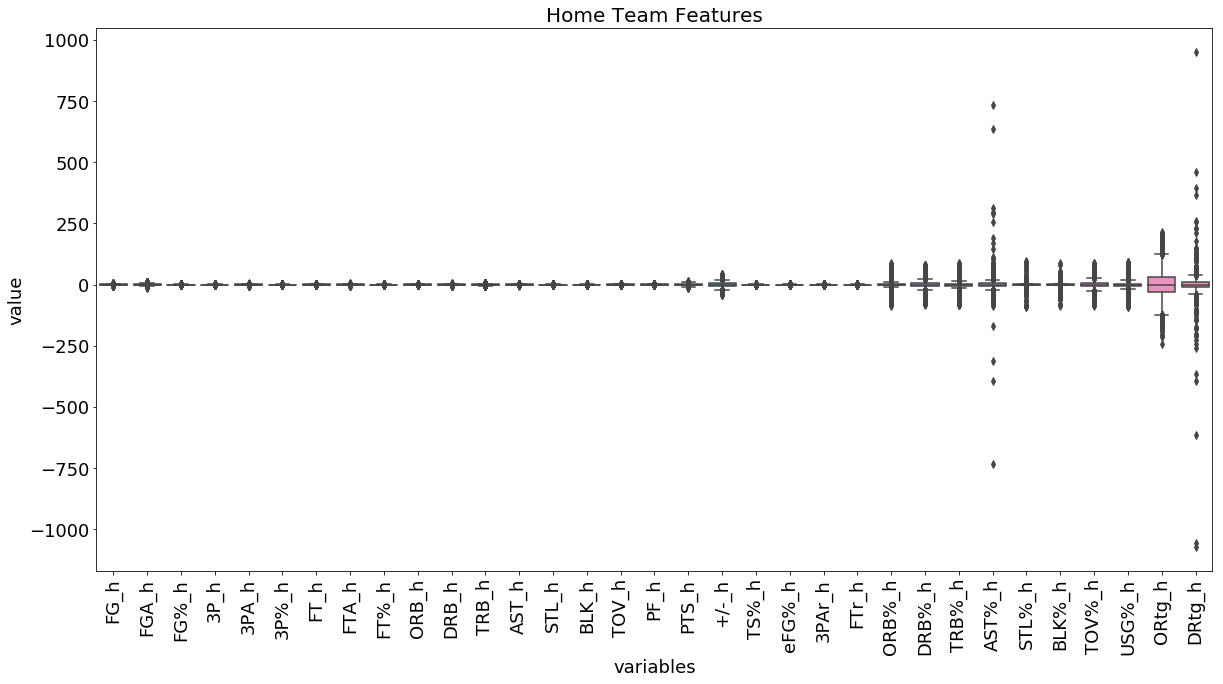

In [112]:
boxplot_features(home_df)

##### Away Team Features

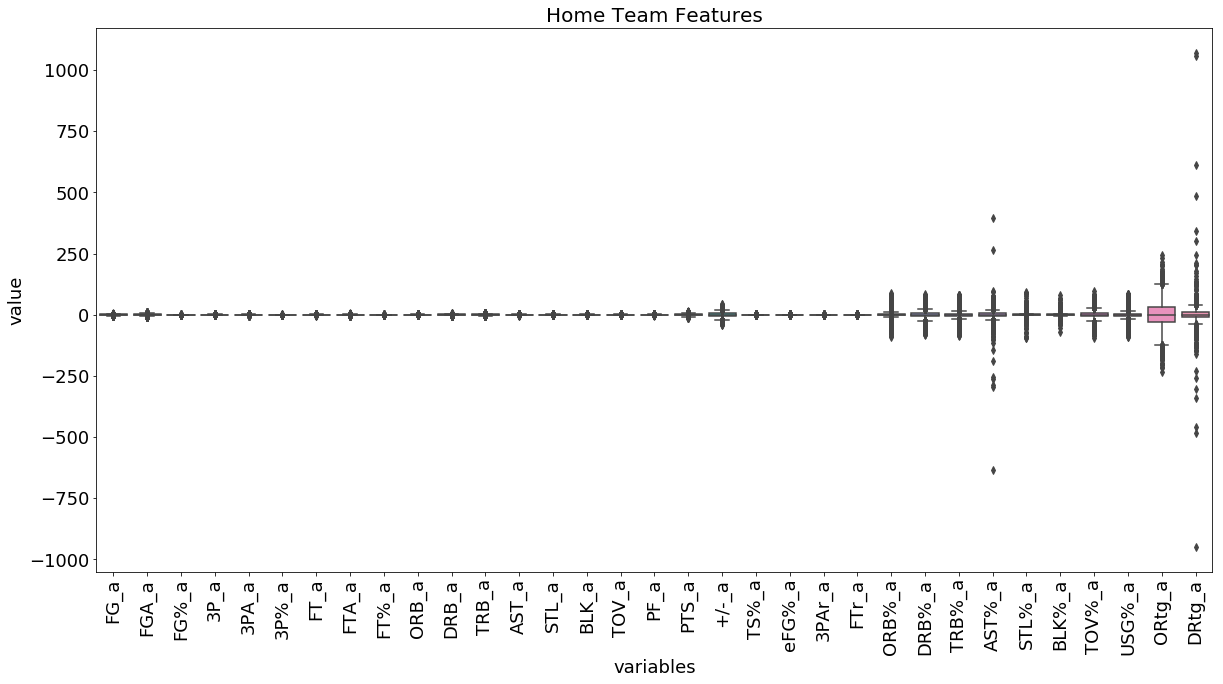

In [113]:
boxplot_features(away_df)

### EDA Part 1: Distribution of Features

#### Home Team Basic Statistics

In [116]:
# where are the home basic features?
home_colname_basic = home_colname[:19]
home_basic_df = clean_df_t1.loc[:, home_colname_basic]
home_basic_df.head(3)

FG_h     FGA_h     FG%_h      3P_h     3PA_h     3P%_h      FT_h  \
1211  0.645228  0.792402  0.080630  0.086097 -0.399348  0.163466 -0.548738   
1212 -2.117701 -4.824676 -0.274895 -0.425487 -0.422551 -0.196546 -0.507883   
1213 -0.329319 -0.692141  0.159542 -0.259508  0.134829 -0.148615  0.274163   

         FTA_h     FT%_h     ORB_h     DRB_h     TRB_h     AST_h     STL_h  \
1211 -0.584930 -0.112230  0.610409 -0.086349  0.524060 -0.391059  0.388937   
1212  0.461844 -0.291756  0.016429 -1.212735 -1.196306 -0.901748 -0.629611   
1213  0.302846  0.063819  0.860348 -0.809918  0.050430 -0.147628  0.141825   

         BLK_h     TOV_h      PF_h     PTS_h      +/-_h  
1211  0.219257  0.032941  0.298708  0.827815   8.923935  
1212  0.032576 -0.544318 -1.578820 -5.168773   3.906356  
1213  0.326963 -0.773978 -1.010362 -0.643984  18.073030

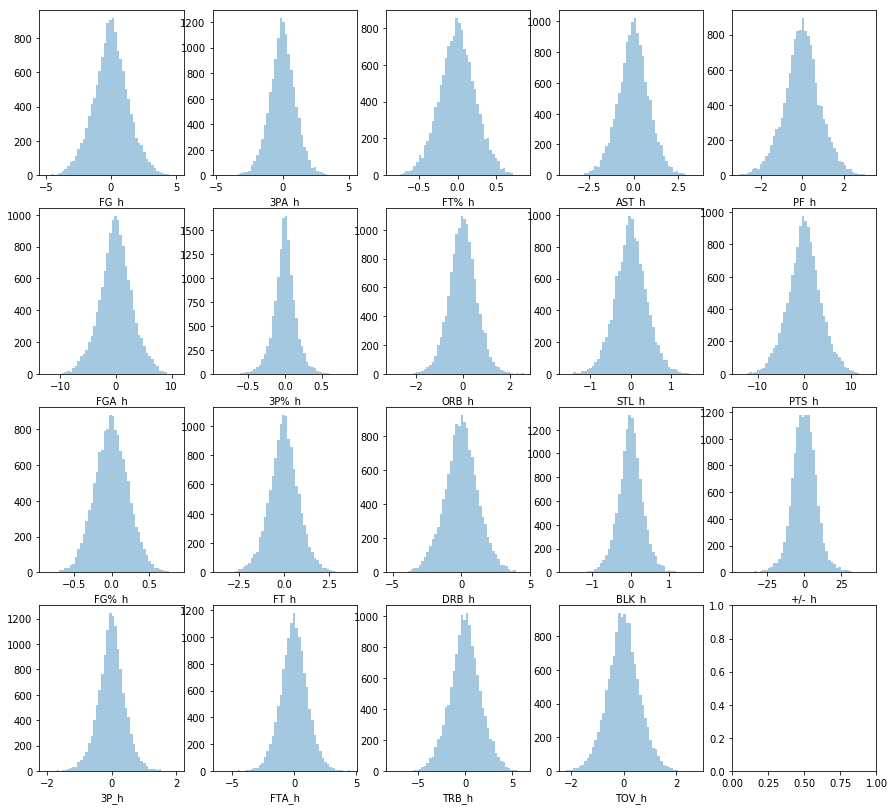

In [118]:
f, axes = plt.subplots(4, 5, figsize=(15, 14), sharex=False)
for i in range(19):
    sns.distplot(home_basic_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Home Team Advanced Statistics

In [119]:
home_colname_ad = home_colname[19:33]
home_advanced_df = final_df_t1.loc[:, home_colname_ad]
home_advanced_df.head(3)

TS%_h    eFG%_h    3PAr_h     FTr_h     ORB%_h    DRB%_h     TRB%_h  \
1211  0.029881  0.085915 -0.141853 -0.242283   4.619424  2.093098   2.204114   
1212 -0.320025 -0.304089  0.017177 -0.084809  55.813133 -6.257992  29.970186   
1213  0.174331  0.155030  0.103024  0.118598  26.148335  7.216073  16.575183   

        AST%_h    STL%_h    BLK%_h     TOV%_h     USG%_h     ORtg_h     DRtg_h  
1211 -8.076030  1.602857  2.395361   1.373305  -0.849849  32.673226 -14.320468  
1212 -6.783023 -1.583346  2.610503  -2.593215  13.248104 -35.676091  -8.194131  
1213  4.370002  3.495973  2.204012 -37.602033  14.855199  31.036221 -30.671251

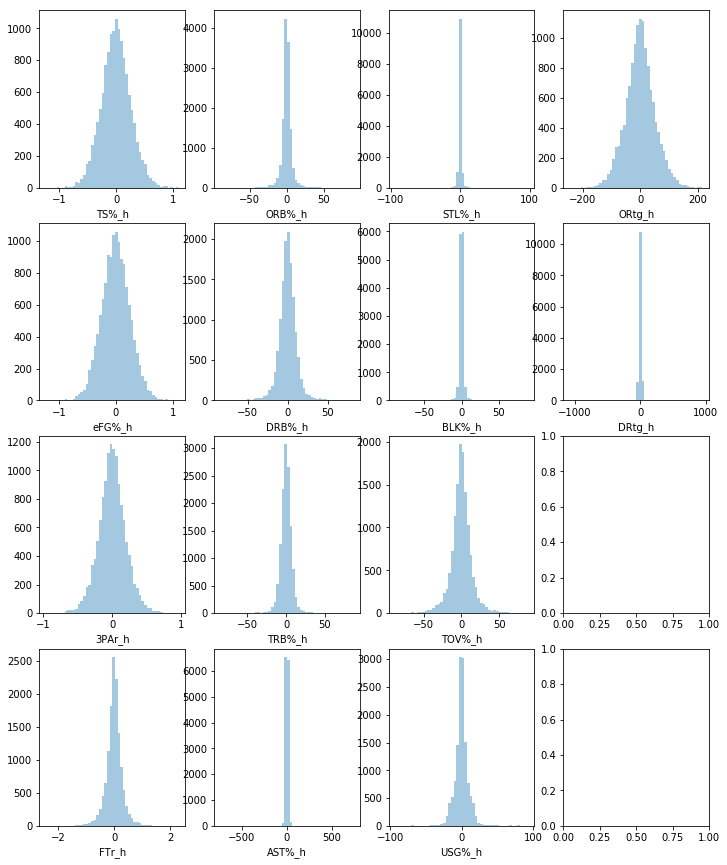

In [120]:
f, axes = plt.subplots(4, 4, figsize=(12, 15), sharex=False)
for i in range(14):
    sns.distplot(home_advanced_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Away Team Basic Statistics

In [ ]:
away_basic_df = final_df_t1.iloc[:, 40:59]
away_basic_df.head(3)

In [ ]:
f, axes = plt.subplots(4, 5, figsize=(15, 14), sharex=False)
for i in range(19):
    sns.distplot(away_basic_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Away Team Advanced Statistics

In [ ]:
away_advanced_df = final_df_t1.iloc[:, 59:73]
away_advanced_df.head(3)

In [ ]:
f, axes = plt.subplots(4, 4, figsize=(12, 15), sharex=False)
for i in range(14):
    sns.distplot(away_advanced_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

### EDA Part 2: Linear Correlation

#### Linearly Correlated Among Independent Variables

In [ ]:
def corrheatmap(correlation):
    # add a mask to the upper right triangle
    heatmap_mask = np.zeros_like(correlation, dtype=np.bool)
    heatmap_mask[np.triu_indices_from(heatmap_mask)] = True

    # adjust the figure size
    f, ax = plt.subplots(figsize=(11, 9))

    # the color bar
    color_map = sns.diverging_palette(220, 10, as_cmap=True)
    # the main heatmap plot
    sns.heatmap(correlation, mask = heatmap_mask, cmap = color_map,
                square = True, linewidths = 3., center = 0,
                vmax = 1, vmin = -1, cbar_kws={"shrink": .7})

##### Home Features

In [ ]:
home_df = final_df_t1.iloc[:, [2]+list(range(5, 38))]
home_corr = home_df.corr()
corrheatmap(home_corr)

##### Away Features

In [ ]:
away_df = final_df_t1.iloc[:, [2]+list(range(40, final_df_t1.shape[1]))]
away_corr = away_df.corr()
corrheatmap(away_corr)

### EDA Part 3: Features Distribution vs. Target Variable Categories

In [ ]:
f, axes = plt.subplots(2, 1, figsize = (12, 15), sharex = False)
data_left = pd.melt(home_df.iloc[:, :-2], id_vars = "HomeWin", var_name="variables", value_name='value')
data_right = pd.melt(home_df.loc[:, ["HomeWin", "ORtg_h", "DRtg_h"]], id_vars = "HomeWin", var_name="variables", value_name='value')
for i in range(2):
    sns.boxplot(x = "variables", y = "value", hue = "HomeWin", data = [data_left, data_right][i], ax = axes[i])
    plt.xticks(rotation=90)

## Preprocessing

### Delete Redundant Dependent Variables

In [ ]:
analysis_table = final_df_t1.drop(["Date", "Game_Index", "Team_h", "Team_id_h", "Team_a", "Team_id_a"], axis = 1)

### train Test Split

Since we randomly split the whole dataset into two, the distribution of the target variable on the training set stays similar and is still unbalanced.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(analysis_table.drop("HomeWin", axis = 1), analysis_table["HomeWin"], test_size = 0.3, random_state = 101)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
sum(y_train == 1) / len(y_train)

### Min Max Scaler

I will scale my continuous features between 0 and 1 so that I will be able to do box-cox transformation with negative value later. The transformation will improve the computation of models which count the distance among data points. In a linear model, the feature with a larger value tends to be more important. Also, it will help speed up the gradient descent. 

In [ ]:
scaler = MinMaxScaler()
X_train.iloc[:,:] = scaler.fit_transform(X_train.values)
X_test.iloc[:,:] = scaler.transform(X_test.values)

### Box-cox Transformation

Conducting log transform may help to normalize a skewed distribution and to get a more robust result.

In [ ]:
X_train_scaled, fitted_lambda = stats.boxcox(X_train)
X_test_scaled = stats.boxcox(test, fitted_lambda)

### SMOTE: Oversampling

## Feature Selestion

Besides directly fitting all the features into the model, I will also do feature selection methods mentioned below. By doing so, we can solve the issues like:

- Curse of Dimensionality (Computation; Overfitting)

- Getting rid of redundant features

Method:

1. Feature Importance

    Based on the feature importance obtained from a decision tree, we can see what features are helpful when doing a categorical problem.


2. Filter Method: Information Gain or Mutual Information

    We will eliminate the independent variables which are not linearly related to the dependent variable. However, this method will neglect the non-linearly relationship.
    
    From the EDA above, we know most of the independent variables are not linearly correlated to the target variable. Therefore, I decided not to use linear correlation as the feature selection method here. Instead, I will try mutual information and 
3. Dimension Reduction

    PCA is a well-known dimention reduction technique. It tends to map the data points from the original dimension to a lower dimensional space and simultaneously, capture most of the variance among the data points. We will also try another method, LDA, which has some assumptions. The variance in each group should be similar and the samples are normally distributed. However sometimes, using a dimension reduction method will make the model hard to be interpretted.

[Feature Selection Reference](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization#Feature-Selection-and-Random-Forest-Classification)

### Feature Importance

[Random Forests]("https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html")

In [ ]:
tuned_parameters = [{'n_estimatorsinteger': [], 'max_depth': [],
                     'max_features': [], 'random_state': [123]}]

clf = GridSearchCV(RandomForestClassifier(),
                   tuned_parameters, scoring = "roc_auc")

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

### Filter Method

#### Drop High Correlated Features

#### Mutual information

In [ ]:
kepler_mutual_information = mutual_info_classif(kepler_X, kepler_y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(kepler.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

#### Variance

In [ ]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

### Dimension Reduction

#### PCA

[PCA Packages]("https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html")

[Pipeline]("https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html")

#### LDA

[LDA Packages]("https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html")

## Model Implementation

- Cross Validation

    1. K Fold CV

    2. Grid Search or Random Search for Hyperparameter


- Model

    1. Logistic Regression (Our Baseline model)
    
    2. Ridge and Lasso Logistic Regression

    3. Random Forest (Bagging)

    4. KNN

    5. XGBoost (Boosting)

    6. SVM


- Metrics

    1. ROC

    2. Accuracy

    3. Recall Rate

    4. Precision

### Pipeline